# Single cell currentscape analysis

Copyright (c) 2025 Open Brain Institute

Authors: Aurélien Jaquier

last modified: 01.2025

## Description

This notebook runs a single cell with a step stimulus, records its mechanism-related currents and voltage output, and plots them as a currentscape graph, in the style of [Alonso and Marder (2019)](https://doi.org/10.7554/eLife.42722).

In order to run this notebook, you will need to download an emodel from the Open Brain Institute Platform. 

You will also need to have Neuron, BlueCelluLab and Currentscape installed.

First, we'll have to load every module that are needed in this notebook:

In [28]:
import json
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile

from bluecellulab import Cell
from bluecellulab.circuit.circuit_access import EmodelProperties
from bluecellulab.simulation import Simulation
from bluecellulab.stimulus import StimulusFactory
from bluecellulab.tools import calculate_rheobase
import currentscape


We'll now open the emodel.zip file, extracts its content and get the path for each file using the metadata.json file:

In [30]:
emodel_folder = Path("emodel")
with zipfile.ZipFile("emodel.zip", mode="r") as archive:
    archive.extractall("./")
with open(emodel_folder / "metadata.json") as f:
    metadata = json.load(f)
hoc_file = emodel_folder / metadata["hoc_file"]
morph_file = emodel_folder / metadata["morph_file"]
mechanisms_folder = emodel_folder / metadata["mechanisms_folder"]
threshold_current = metadata["threshold_current"]
holding_current = metadata["holding_current"]
emodel_name = metadata["emodel_name"]

You will now need to compile the mechanisms that are in the emodel folder created after the zip file extraction. Run the following cell to compile the mechanisms:

In [ ]:
!nrnivmodl emodel/mechanisms

Now, we will get the holding current and the threshold current from the metadata. If they are not available, we will use default values of 0 for both for now, and compute the threshold current later on.

In [32]:
if holding_current is None:
    print("No holding current provided, will set it to 0.")
    holding_current = 0
compute_threshold = False
if threshold_current is None:
    compute_threshold = True
    threshold_current = 0
emodel_properties = EmodelProperties(
    threshold_current=threshold_current,
    holding_current=holding_current,
)

Now that we have the holding and threshold current (or placeholder values if they were not in the metadata), we can create our cell using BlueCelluLab:

In [33]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

Now that we have a cell, we can compute its threshold current if it was not provided in the metadata. First, we compute its RMP (resting membrane potential) and Rin (internal resistance) to get a maximum bound for threshold current, and use a bisection search algorithm. BlueCelluLab can handle all of that:

In [34]:
if compute_threshold:
    print("No threshold current provided, will attempt to compute it. This will take a few seconds...")
    emodel_properties.threshold_current = calculate_rheobase(cell)

And we can print the holding and threshold currents:

In [35]:
print(f"holding current is {emodel_properties.holding_current} nA.")
print(f"threshold current is {emodel_properties.threshold_current} nA.")

holding current is -0.0640625 nA.
threshold current is 0.08304913631110189 nA.


We will now create a protocol with a step stimulus.

For this we will use bluecellulab's idrest protocol. Its stimulus delay and duration are hardcoded. If you want to set them, you will have to directly use bluecellulab.stimulus.factory.Step. We have to set the protocol amplitude.

Here, we will set it to 150% of the rheobase, but feel free to play with this number and compare the different outputs. We can also set the time step. Here, we will set to 0.1 ms. Once again, BlueCelluLab takes care of creating the stimulus for us:

In [36]:
threshold_percentage = 150
stim_factory = StimulusFactory(dt=0.1)
stim = stim_factory.idrest(
    threshold_current=emodel_properties.threshold_current,
    threshold_percentage=threshold_percentage
)

Next we have to define the ion channels that we want to record. For this example, let's record all of those present in the soma.

You have to give the channel suffix and the current it writes to. You can find them in the ion channel mod file (in the mechanisms folder) in the NEURON block under SUFFIX for the suffix and either under USEION WRITE or under NONSPECIFIC_CURRENT for the current, depending on whether it is an ionic current or a non-specific current.

You don't have to add mechanisms that do not write ionic current, like CaDynamics_DC0. Here, we won't record Nap_Et2 either because this channel is not present in the soma. We will also add the pas channel. Its mod file is taken directly from Neuron, which is why it is not present in the mechanisms folder.

In [37]:
ion_channels = {
    "SKv3_1": "ik",
    "K_Pst": "ik",
    "SK_E2": "ik",
    "K_Tst": "ik",
    "Ca_LVAst": "ica",
    "Ca_HVA2": "ica",
    "NaTg": "ina",
    # "Nap_Et2": "ina",  # mechanism not in soma
    "Ih": "ihcn",
    "pas": "i",
}

Next we have to add recordings for all of those ion channel currents:

In [38]:
current_rec_names = [
    f"self.soma(0.5)._ref_{curr_name}_{ion_channel}"
    for ion_channel, curr_name 
    in ion_channels.items()
]
for current_rec in current_rec_names:
    cell.add_recording(current_rec)

Now, we can inject the stimulus into the cell, and run it. Note that this can take a few seconds to run.

In [39]:
cell.inject_current_waveform(t_content=stim.time, i_content=stim.current)
sim = Simulation(cell)
print("Running the simulation...")
sim.run(stim.stimulus_time, dt=0.1)
print("Done.")

Running the simulation...
Done.


We can retrieve the time, voltage and the currents from our simulation:

In [40]:
currents = []
time, voltage = cell.get_time(), cell.get_soma_voltage()
for current_rec in current_rec_names:
    currents.append(cell.get_recording(current_rec))

Now we have make a configuration for currentscape. The most important thing is to give the list of current names that are going to be displayed on the plot legend, in the exact same order as we have in the `currents` recording output.

Here we also give a title to the figure, and set it so that the figure will be saved automatically. For a complete list of available configurations, see [this explanation](https://github.com/BlueBrain/Currentscape/blob/main/Tutorial.rst#about-the-config).

In [41]:
currentscape_config = {
    "current": {"names": list(ion_channels.keys())},
    "output": {
        "savefig": True,
        "dir": ".",
        "fname": f"currentscape-{emodel_name}-step{threshold_percentage}",
        "extension": "pdf",
        "transparent": False
    },
    "title": f"currentscape {threshold_percentage}% rheobase of {emodel_name}",
    "titlesize": 14,
    "legend": {
        "textsize": 10
    },
    "figsize": [15, 10],
    "textsize": 10
}

Finally, we can plot our currentscape:

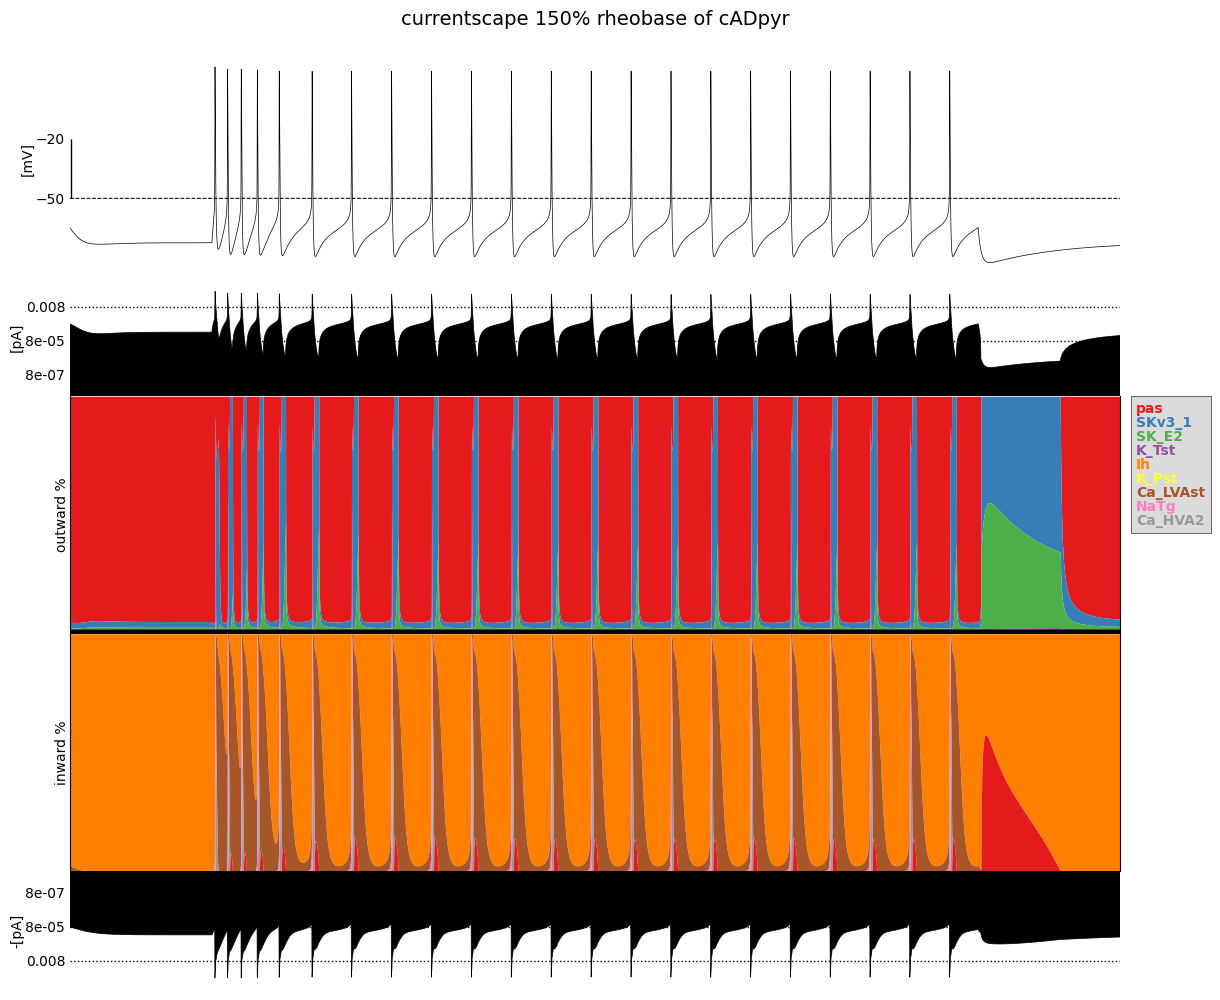

In [42]:
fig = currentscape.plot(
    voltage,
    currents,
    currentscape_config,
    ions_data=None,
    time=time,
)
plt.show()

Note that if you want to plot several plots, it is recommended to close each figure before plotting the next one:

In [13]:
plt.close(fig)